<a href="https://colab.research.google.com/github/Ayanlola2002/Data-Science-Nigeria/blob/DSN_best_car_price_prediction_2019/best_car_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [54]:
!kaggle competitions download -c dsn-recruitment-service-test

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzippig the us-data file
from shutil import unpack_archive
#unpack_archive('all.zip')
unpack_archive('train.csv.zip')
unpack_archive('test.csv.zip')

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [0]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
#train = pd.read_csv('train.csv',parse_dates=[['weblog_date'],['date_of_advert'],['last_advert_online']])
#test = pd.read_csv('test.csv',parse_dates=[weblog_date],[[date_of_advert],[last_advert_online])
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
train_copy=train.copy()
test_copy=test.copy()

In [61]:
##display the first five rows of the train dataset.
train.head()

,id,seller_type,country_of_use,weblog_date,Area_address_code,car_name,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,car_brand,Status_of_car_repair,gear_type,date_of_advert,last_advert_online,model,naira_price
0,34946,private,london,2016-03-15,78183,Smart_smart_forfour_pulse,small car,2007,11,95,241350.000,gasoline,smart,nein,manuell,2016-03-15,2016-03-16,forfour,864000
1,298886,private,london,2016-04-01,47166,Seat_Arosa_1.4_16V,small car,2003,7,101,241350.000,gasoline,seat,nein,manuell,2016-04-01,2016-04-03,arosa,630000
2,104362,private,london,2016-03-17,44623,Woll_fahrbereit,small car,1999,8,90,241350.000,NaN,opel,NaN,manuell,2016-03-17,2016-04-07,tigra,180000
3,300368,private,london,2016-03-29,53945,Skoda_Fabia_5_Tuerer_dunkelblau_metallic,limousine,2003,6,68,201125.000,gasoline,skoda,NaN,manuell,2016-03-29,2016-03-29,fabia,432000
4,207699,private,london,2016-03-24,45886,Verkaufe_mein_Auto_#_Jeep_#_Hyundai_#_Tucson_#,other,2008,0,120,241350.000,NaN,hyundai,NaN,automatik,2016-03-24,2016-04-05,tucson,1692000


In [62]:
##display the first five rows of the test dataset.
test.head()

,id,seller_type,country_of_use,weblog_date,Area_address_code,car_name,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,car_brand,Status_of_car_repair,gear_type,date_of_advert,last_advert_online,model
0,72959,private,london,2016-03-20,24768,Opel_vectra_B_1.6_16v_tuev_09.2017,limousine,2000,9,101,201125.000,gasoline,opel,nein,automatik,2016-03-20,2016-03-21,vectra
1,8681,private,london,2016-03-27,26629,Aixam_45_km/h_Auto_automatiek_nicht_fahrbereit,other,2005,6,0,32180.000,NaN,sonstige_autos,NaN,automatik,2016-03-27,2016-04-05,NaN
2,238202,private,london,2016-03-22,35606,Passat_Alltrack_Bluemotion,station wagon,2018,1,0,32180.000,diesel,volkswagen,ja,NaN,2016-03-22,2016-04-06,passat
3,110743,private,london,2016-03-28,59192,Opel_Kadett,limousine,1979,9,110,241350.000,gasoline,opel,nein,manuell,2016-03-28,2016-03-31,kadett
4,34925,private,london,2016-04-02,7551,"Seat_Arosa_""Anfaengerauto_Stadtflitzer""_TÜV_02...",small car,2000,8,0,241350.000,gasoline,seat,NaN,manuell,2016-04-02,2016-04-06,arosa


In [64]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['id']
test_ID = test['id']





The train data size before dropping Id feature is : (224524, 19) 
The test data size before dropping Id feature is : (110587, 18) 


In [67]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

KeyError: ignored

In [68]:
#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (224524, 18) 
The test data size after dropping Id feature is : (110587, 17) 


In [0]:
#separate categorical varriable from numerical varriable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [70]:
quantitative

['Area_address_code',
 'Permit_registration_year',
 'registration_month',
 'horse_power',
 'mileage',
 'naira_price']

In [71]:
qualitative

['seller_type',
 'country_of_use',
 'weblog_date',
 'car_name',
 'car_type',
 'gas_type',
 'car_brand',
 'Status_of_car_repair',
 'gear_type',
 'date_of_advert',
 'last_advert_online',
 'model']

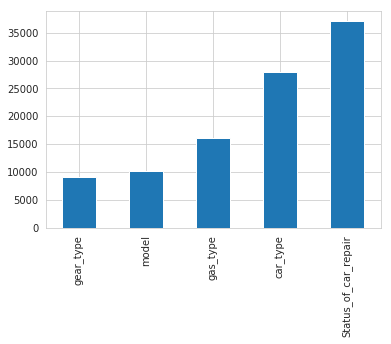

In [18]:
#missing values
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [72]:
# check number & percentage of missing value in the columns
def missing_values_table(df):
  mis_val = df.isnull().sum() #total missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #make a table with the results
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename the columns
     # sort the table by percentage of missing value
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        #print same summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

          # return the dataframe with missing information
  return mis_val_table_ren_columns
  
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 18 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Status_of_car_repair,37087,16.500
car_type,27959,12.500
gas_type,16091,7.200
model,10248,4.600
gear_type,9133,4.100


In [73]:
train['car_type'].unique()

array(['small car', 'limousine', 'other', 'bus', nan, 'convertible',
       'station wagon', 'coupé'], dtype=object)

In [0]:
#fill nan values with others
#will be one-hot encoded
train['car_type']=train["car_type"].fillna('other')

In [75]:
train['car_type'].value_counts()

limousine        60125
small car        45814
station wagon    42371
other            29888
bus              19639
convertible      14952
coupé            11735
Name: car_type, dtype: int64

In [76]:
train['gas_type'].unique()

array(['gasoline', nan, 'diesel', 'liquefied petroleum gas',
       'compressed natural gas', 'other'], dtype=object)

In [0]:
#fill nan with others
train['gas_type']=train["gas_type"].fillna('other')

In [78]:
#one hot encoding will be done
train['gas_type'].value_counts()

gasoline                   134042
diesel                      70531
other                       16179
liquefied petroleum gas      3405
compressed natural gas        367
Name: gas_type, dtype: int64

In [79]:
#remove the model the car type can represent model
train['model'].unique()

array(['forfour', 'arosa', 'tigra', 'fabia', 'tucson', 'scenic',
       'a_klasse', 'mx_reihe', 'c_klasse', 'v50', 'lupo', 'polo',
       'touareg', nan, 'c4', 'micra', 'golf', 'q5', 'toledo', 'santa',
       'v40', 'andere', '100', '3er', 'corsa', 'yaris', 'clk', 'cl',
       'punto', 'cayenne', 'corolla', 'vito', 'focus', 'passat',
       'x_reihe', '2_reihe', '1_reihe', 'astra', 'seicento',
       'transporter', 'a4', 'colt', 'octavia', 'c_reihe', '5er', 'cooper',
       'vectra', 'insignia', '3_reihe', 'a6', 'fiesta', 'agila',
       'impreza', '7er', 'accord', 'a3', 'beetle', '147', 'grand', 'leon',
       'combo', 'megane', 'twingo', 'clio', 'z_reihe', 'xc_reihe', '1er',
       'phaeton', 'ibiza', 'verso', 'slk', 'civic', 'a5', 'swift', 'rav',
       'caddy', 'up', 'touran', 'yeti', 'sharan', '4_reihe', 'matiz',
       'i_reihe', 'stilo', 'e_klasse', 'mondeo', 'wrangler', 'kangoo',
       'superb', 'fortwo', 'meriva', 'bora', 'sportage', 'cordoba', 'a1',
       'm_klasse', 'legac

In [0]:
#model removed
#train.drop("model", axis = 1, inplace = True)
#test.drop("model", axis = 1, inplace = True)

In [83]:
#handling Missing Values
#to be one hot encoded
train['gear_type'].value_counts()

manuell      165717
automatik     49674
Name: gear_type, dtype: int64

In [84]:
train['gear_type'].unique()

array(['manuell', 'automatik', nan], dtype=object)

In [0]:
train['gear_type']=train['gear_type'].fillna('Not_Available')

In [86]:
#one hot encode
train['gear_type'].value_counts()

manuell          165717
automatik         49674
Not_Available      9133
Name: gear_type, dtype: int64

In [87]:
# to be one hot encoded
train['Status_of_car_repair'].value_counts()

nein    169545
ja       17892
Name: Status_of_car_repair, dtype: int64

In [88]:
train['Status_of_car_repair'].unique()

array(['nein', nan, 'ja'], dtype=object)

In [89]:
#one hot encode 
train['Status_of_car_repair']=train['Status_of_car_repair'].fillna('Not_available')
# to be one hot encoded
train['Status_of_car_repair'].value_counts()

nein             169545
Not_available     37087
ja                17892
Name: Status_of_car_repair, dtype: int64

In [90]:
type(train)

pandas.core.frame.DataFrame

In [91]:
#convert seller typeto a numeric value
#use label-encoder
train['seller_type'].value_counts()


private    224524
Name: seller_type, dtype: int64

In [92]:
#label encoder
train['country_of_use'].value_counts()

london    224524
Name: country_of_use, dtype: int64

In [0]:
#remove car_brand can be categorized with car_type
#train['car_brand'].unique()

In [0]:
#dropping car_brand and car_name
train.drop(['car_brand','car_name'],axis=1,inplace=True)

test.drop(['car_brand','car_name'],axis=1,inplace=True)

In [94]:
train.head()

,seller_type,country_of_use,weblog_date,Area_address_code,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,Status_of_car_repair,gear_type,date_of_advert,last_advert_online,naira_price
0,private,london,2016-03-15,78183,small car,2007,11,95,241350.000,gasoline,nein,manuell,2016-03-15,2016-03-16,864000
1,private,london,2016-04-01,47166,small car,2003,7,101,241350.000,gasoline,nein,manuell,2016-04-01,2016-04-03,630000
2,private,london,2016-03-17,44623,small car,1999,8,90,241350.000,other,Not_available,manuell,2016-03-17,2016-04-07,180000
3,private,london,2016-03-29,53945,limousine,2003,6,68,201125.000,gasoline,Not_available,manuell,2016-03-29,2016-03-29,432000
4,private,london,2016-03-24,45886,other,2008,0,120,241350.000,other,Not_available,automatik,2016-03-24,2016-04-05,1692000


In [0]:
# converting dates into datetime format

train['weblog_date'] = pd.to_datetime(train['weblog_date'], errors = 'coerce')
#train['date_of_advert'] = pd.to_datetime(train['date_of_advert'], errors = 'coerce')
train['last_advert_online'] = pd.to_datetime(train['last_advert_online'], errors = 'coerce')
# extracting out years, months, days and weeks from the date
#train['weblog_date_year'] = train['weblog_date'].dt.year
#train['weblog_date_month'] = train['weblog_date'].dt.month
#train['date_of_advert_year'] = train['date_of_advert'].dt.year
#train['date_of_advert_month'] = train['date_of_advert'].dt.month
#train['last_advert_online_year'] = train['last_advert_online'].dt.year
#train['last_advert_online_month'] = train['last_advert_online'].dt.month




In [0]:
test['weblog_date'] = pd.to_datetime(test['weblog_date'], errors = 'coerce')
#test['date_of_advert'] = pd.to_datetime(test['date_of_advert'], errors = 'coerce')
test['last_advert_online'] = pd.to_datetime(test['last_advert_online'], errors = 'coerce')

# extracting out years, months, days and weeks from the date

#test['weblog_date_year'] = test['weblog_date'].dt.year
#test['weblog_date_month'] = test['weblog_date'].dt.month

#test['date_of_advert_year'] = test['date_of_advert'].dt.year
#test['date_of_advert_month'] = test['date_of_advert'].dt.month

#test['last_advert_online_year'] = test['last_advert_online'].dt.year
#test['last_advert_online_month'] = test['last_advert_online'].dt.month

In [0]:
#Difference advert dates in days for train
train['advert_days_diff']=train['last_advert_online']-train['weblog_date']

In [0]:
#Difference advert dates in days for test
test['advert_days_diff']=test['last_advert_online']-test['weblog_date']

In [0]:
 #remove this features date_of_advert,weblogdate,last_advert_online
 #weblog date and date of advert looks same
train.drop(['date_of_advert','weblog_date','last_advert_online'],inplace=True,axis=1)

In [0]:
 test.drop(['date_of_advert','weblog_date','last_advert_online'],inplace=True,axis=1)

In [101]:
train.head()

,seller_type,country_of_use,Area_address_code,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,Status_of_car_repair,gear_type,naira_price,advert_days_diff
0,private,london,78183,small car,2007,11,95,241350.000,gasoline,nein,manuell,864000,1 days
1,private,london,47166,small car,2003,7,101,241350.000,gasoline,nein,manuell,630000,2 days
2,private,london,44623,small car,1999,8,90,241350.000,other,Not_available,manuell,180000,21 days
3,private,london,53945,limousine,2003,6,68,201125.000,gasoline,Not_available,manuell,432000,0 days
4,private,london,45886,other,2008,0,120,241350.000,other,Not_available,automatik,1692000,12 days


In [102]:
test.head()

,seller_type,country_of_use,Area_address_code,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,Status_of_car_repair,gear_type,advert_days_diff
0,private,london,24768,limousine,2000,9,101,201125.000,gasoline,nein,automatik,1 days
1,private,london,26629,other,2005,6,0,32180.000,NaN,NaN,automatik,9 days
2,private,london,35606,station wagon,2018,1,0,32180.000,diesel,ja,NaN,15 days
3,private,london,59192,limousine,1979,9,110,241350.000,gasoline,nein,manuell,3 days
4,private,london,7551,small car,2000,8,0,241350.000,gasoline,NaN,manuell,4 days


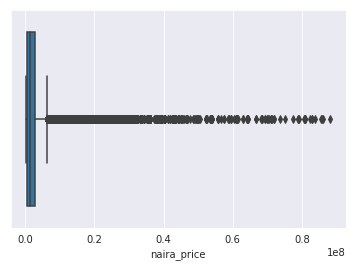

In [103]:
#remove outliers
sns.boxplot(x=train['naira_price'])

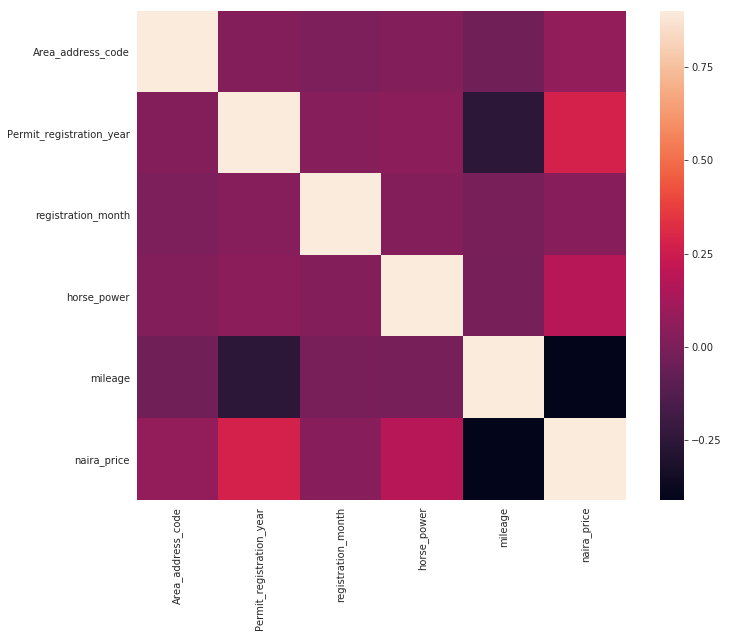

In [104]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [105]:
#the category types
['seller_type',
 'country_of_use',
 'weblog_date',
 'car_name',
 'car_type',
 'gas_type',
 'car_brand',
 'Status_of_car_repair',
 'gear_type',
 'date_of_advert',
 'last_advert_online',
 'model']

['seller_type',
 'country_of_use',
 'weblog_date',
 'car_name',
 'car_type',
 'gas_type',
 'car_brand',
 'Status_of_car_repair',
 'gear_type',
 'date_of_advert',
 'last_advert_online',
 'model']

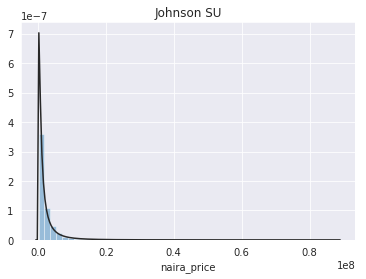

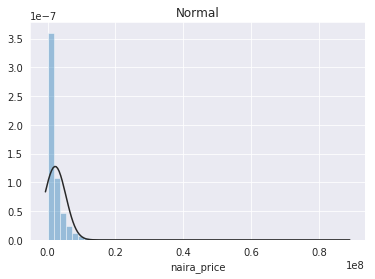

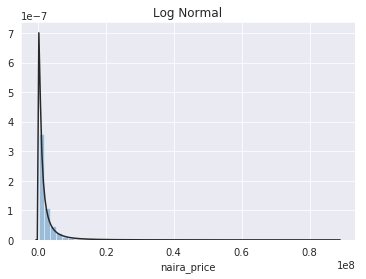

In [106]:
#handling the prize predictor varriable
y = train['naira_price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)


 mu = 2262567.00 and sigma = 3123093.25



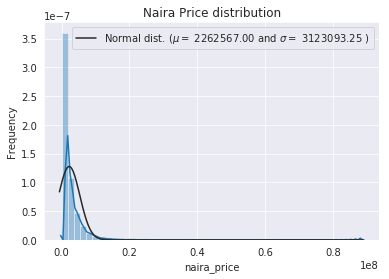

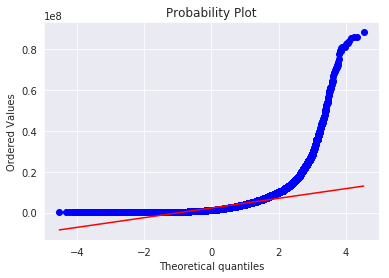

In [107]:
sns.distplot(train['naira_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['naira_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Naira Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['naira_price'], plot=plt)
plt.show()


 mu = 2.71 and sigma = 0.07



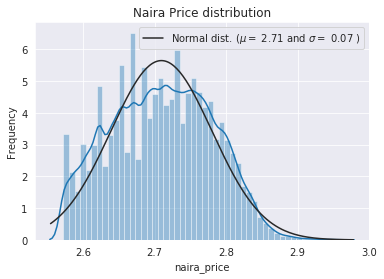

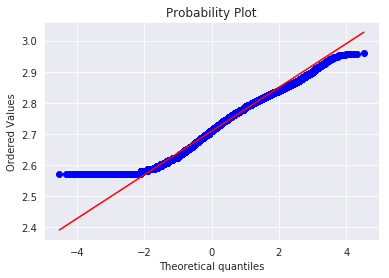

In [109]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["naira_price"] = np.log1p(train["naira_price"])

#Check the new distribution 
sns.distplot(train['naira_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['naira_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Naira Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['naira_price'], plot=plt)
plt.show()

In [0]:
train_ID=train_ID.astype(float)

In [111]:
type(train_ID)

pandas.core.series.Series

In [0]:

#apply SelectKBest class to extract top 10 best features
#bestfeatures = SelectKBest(score_func=chi2, k=10)
#fit = bestfeatures.fit(quantitative,train_ID)
#dfscores = pd.DataFrame(fit.scores_)
#dfcolumns = pd.DataFrame(quantitative.columns)
#concat two dataframes for better visualization 
#featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [0]:
#train['car_type'].value_counts()

In [0]:
"""
def car_type_cat(cat):
  if cat=='limousine':
    return 1
  elif cat=='small car':
    return 2
  elif cat=='station wagon':
    return 3
  elif cat=='bus':
    return 4
  elif cat=='convertible':
    return 5
  elif cat=='coupé':
    return 6
  else:
    return 7
"""
  

In [0]:
#train['gas_type'].value_counts()

In [0]:
"""
def gas_type_cat(cat):
  if cat=='gasoline':
    return 1
  elif cat=='diesel':
    return 2
  elif cat=='liquefied petroleum gas':
    return 3
  elif cat=='compressed natural gas':
    return 4
  else:
    return 5
"""


In [0]:
#train['car_type']=train['car_type'].apply(car_type_cat)
#test['car_type']=test['car_type'].apply(car_type_cat)

In [0]:
#train['gas_type']=train['gas_type'].apply(gas_type_cat)
#test['gas_type']=test['gas_type'].apply(gas_type_cat)

In [0]:
#extracting year and month from date
#!conda update pandas

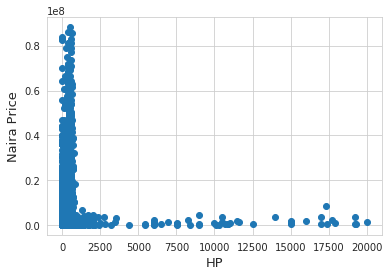

In [0]:
#check outliars
fig, ax = plt.subplots()
ax.scatter(x = train['horse_power'], y = train['naira_price'])
plt.ylabel('Naira Price', fontsize=13)
plt.xlabel('HP', fontsize=13)
plt.show()

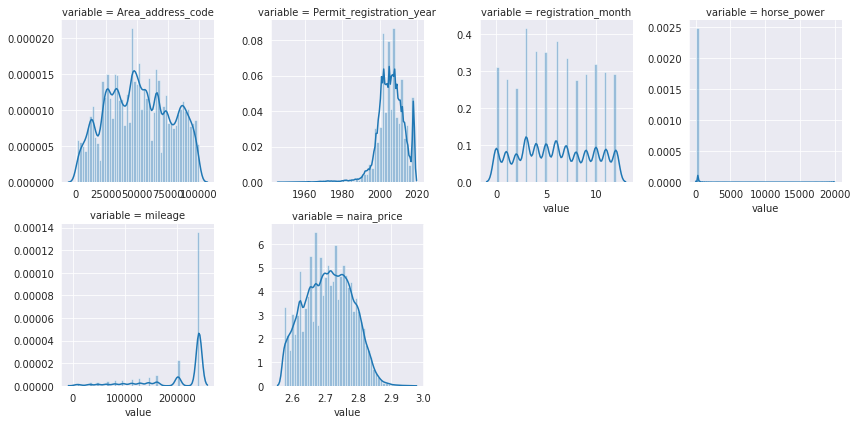

In [113]:
#create numeric plots
#num = [f for f in train.columns if train.dtypes[f] != 'object']
num=quantitative
#num.remove('Id')
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1